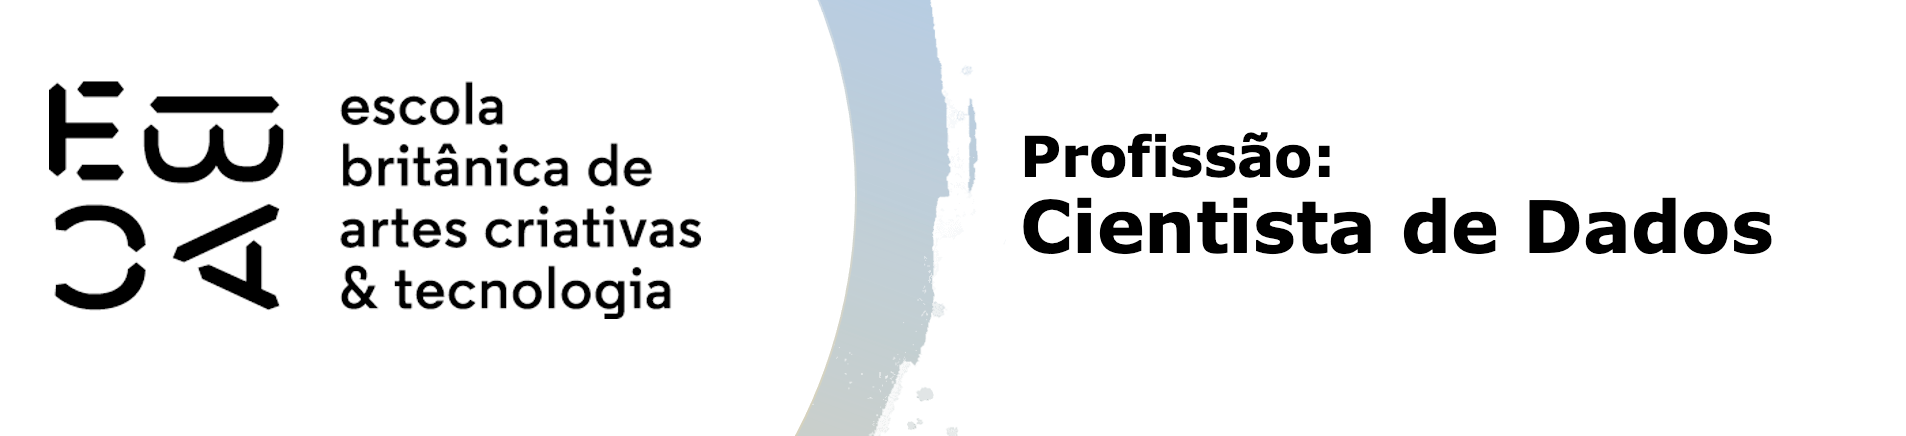

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [27]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [21]:
# Converter a variável data_ref para datetime para facilitar a manipulação
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Remover a variável 'index' por ser apenas um identificador
df = df.drop(columns=['index'], errors='ignore')

# Identificar variáveis numéricas e categóricas
variaveis_numericas = df.select_dtypes(include=['float64', 'int64']).columns.difference(['mau'])
variaveis_categoricas = df.select_dtypes(include=['object']).columns

# Verificar a presença de valores nulos
dados_nulos = df.isnull().sum()
print("Valores nulos por variável:")
print(dados_nulos[dados_nulos > 0])

# Definir estratégias de imputação
imputer_numerico = SimpleImputer(strategy='median')  # Substitui nulos por mediana
imputer_categorico = SimpleImputer(strategy='most_frequent')  # Substitui nulos pelo valor mais frequente

# Criar pipeline para pré-processamento
preprocessador = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', imputer_numerico), ('scaler', StandardScaler())]), variaveis_numericas),
        ('cat', Pipeline([('imputer', imputer_categorico), ('encoder', OneHotEncoder(handle_unknown='ignore'))]), variaveis_categoricas)
    ]
)

# Aplicar o pipeline na base
df_preprocessado = preprocessador.fit_transform(df)

print("Pré-processamento concluído.")

Valores nulos por variável:
tempo_emprego    125957
dtype: int64
Pré-processamento concluído.


### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [8]:
# Identificação e tratamento de outliers
for col in variaveis_numericas:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr
    
    # Substituir outliers por limites inferior/superior
    df[col] = np.where(df[col] < limite_inferior, limite_inferior, df[col])
    df[col] = np.where(df[col] > limite_superior, limite_superior, df[col])

# Criar pipeline para pré-processamento
preprocessador = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', imputer_numerico), ('scaler', StandardScaler())]), variaveis_numericas),
        ('cat', Pipeline([('imputer', imputer_categorico), ('encoder', OneHotEncoder(handle_unknown='ignore'))]), variaveis_categoricas)
    ]
)

# Aplicar o pipeline na base
df_preprocessado = preprocessador.fit_transform(df)

print("Pré-processamento concluído, incluindo tratamento de outliers.")

Pré-processamento concluído, incluindo tratamento de outliers.


### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [23]:
# Separar variáveis preditoras e alvo
X = df[variaveis_numericas.tolist() + variaveis_categoricas.tolist()]
y = df['mau']

# Dividir a base em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Aplicar pré-processamento na base de treino
X_train_transf = preprocessador.fit_transform(X_train)
X_test_transf = preprocessador.transform(X_test)

# Obter os nomes das colunas após a transformação
nomes_numericos = variaveis_numericas.tolist()
nomes_categoricos = preprocessador.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(variaveis_categoricas).tolist()
nomes_finais = nomes_numericos + nomes_categoricos

# Treinar modelo RandomForestClassifier
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_train_transf, y_train)

# Selecionar variáveis mais importantes
seletor = SelectFromModel(modelo_rf, threshold='median', prefit=True)
variaveis_selecionadas = np.array(nomes_finais)[seletor.get_support()]

print("Variáveis selecionadas:", variaveis_selecionadas)
print("Pré-processamento e seleção de variáveis concluídos.")

Variáveis selecionadas: ['idade' 'qt_pessoas_residencia' 'qtd_filhos' 'renda' 'tempo_emprego'
 'sexo_F' 'posse_de_veiculo_N' 'posse_de_veiculo_S'
 'tipo_renda_Assalariado' 'tipo_renda_Empresário' 'educacao_Médio'
 'educacao_Superior completo' 'estado_civil_Casado'
 'estado_civil_Solteiro' 'estado_civil_União' 'tipo_residencia_Casa']
Pré-processamento e seleção de variáveis concluídos.


### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [29]:
# Aplicar PCA para reduzir a dimensionalidade para 5 componentes
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_transf)
X_test_pca = pca.transform(X_test_transf)

# Treinar modelo RandomForestClassifier com dados reduzidos
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_train_pca, y_train)

print("PCA aplicado: Redução para 5 componentes concluída.")

PCA aplicado: Redução para 5 componentes concluída.


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [31]:
variaveis_categoricas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

# Criar dummies para variáveis categóricas
df = pd.get_dummies(df, columns=variaveis_categoricas, drop_first=True)

df.head()

,data_ref,index,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,sexo_M,posse_de_veiculo_S,...,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,2015-01-01,5733,0,43,6.873973,1.0,2515.39,False,False,False,...,False,False,True,False,False,True,False,False,False,False
1,2015-01-01,727,0,35,4.526027,2.0,3180.19,False,False,True,...,False,False,False,False,False,True,False,False,False,False
2,2015-01-01,6374,2,31,0.243836,4.0,1582.29,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,2015-01-01,9566,0,54,12.772603,2.0,13721.17,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,2015-01-01,9502,0,31,8.432877,1.0,2891.08,False,False,True,...,True,False,True,False,False,True,False,False,False,False


### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [37]:
# Carregar a base de dados
def carregar_dados(file_path='credit_scoring.ftr'):
    df = pd.read_feather(file_path)
    df['data_ref'] = pd.to_datetime(df['data_ref'])
    df = df.drop(columns=['index', 'data_ref'], errors='ignore')  # Removendo data_ref
    return df

# Função de pré-processamento
def preprocessamento(df):
    variaveis_numericas = df.select_dtypes(include=['float64', 'int64']).columns.difference(['mau'])
    variaveis_categoricas = df.select_dtypes(include=['object']).columns  # Considerar todas as categóricas
    
    return df, variaveis_numericas, variaveis_categoricas

# Função principal para executar o pipeline
def executar_pipeline():
    df = carregar_dados()
    df, variaveis_numericas, variaveis_categoricas = preprocessamento(df)
    
    # Separar variáveis preditoras e alvo
    X = df.drop(columns=['mau'])
    y = df['mau']
    
    # Dividir a base em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Criar pipeline de pré-processamento
    preprocessador = ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), variaveis_numericas),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), variaveis_categoricas)
    ])
    
    # Criar pipeline final
    pipeline = Pipeline([
        ('preprocessador', preprocessador),
        ('pca', PCA(n_components=5)),
        ('modelo', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    # Treinar modelo
    pipeline.fit(X_train, y_train)
    
    print("Pipeline concluído com sucesso.")
    return pipeline, X_test, y_test

# Executar pipeline
pipeline, X_test, y_test = executar_pipeline()


Pipeline concluído com sucesso.


# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(643124, 17)"
4,Transformed data shape,"(643124, 36)"
5,Transformed train set shape,"(450186, 36)"
6,Transformed test set shape,"(192938, 36)"
7,Ordinal features,2
8,Numeric features,9
9,Date features,1


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.9117,0.7578,0.0276,0.5304,0.0524,0.0441,0.1058


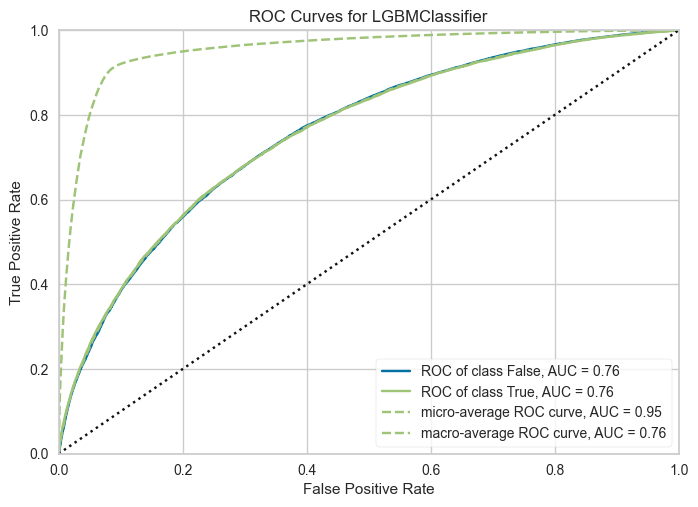

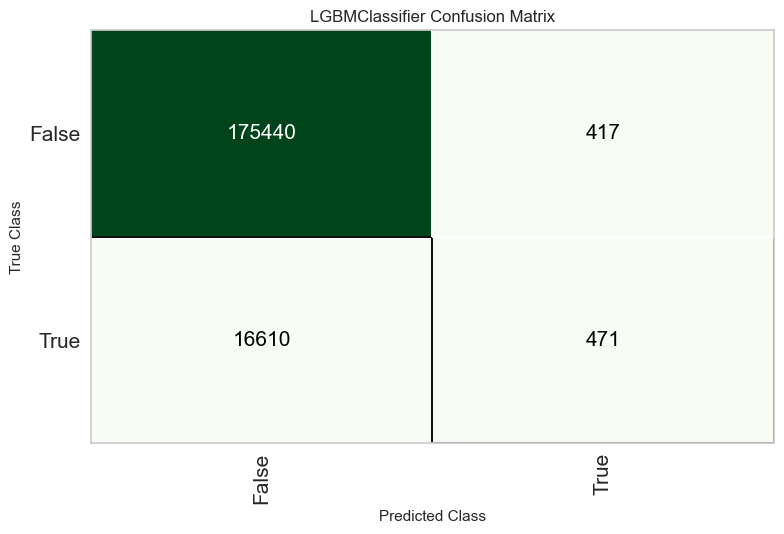

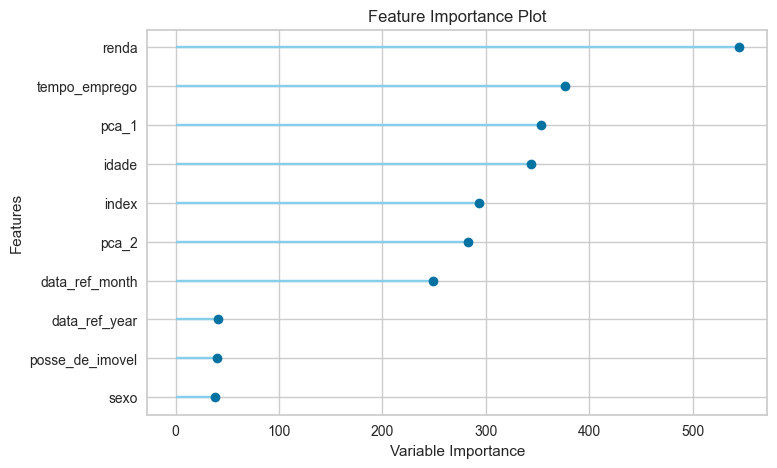

Transformation Pipeline and Model Successfully Saved


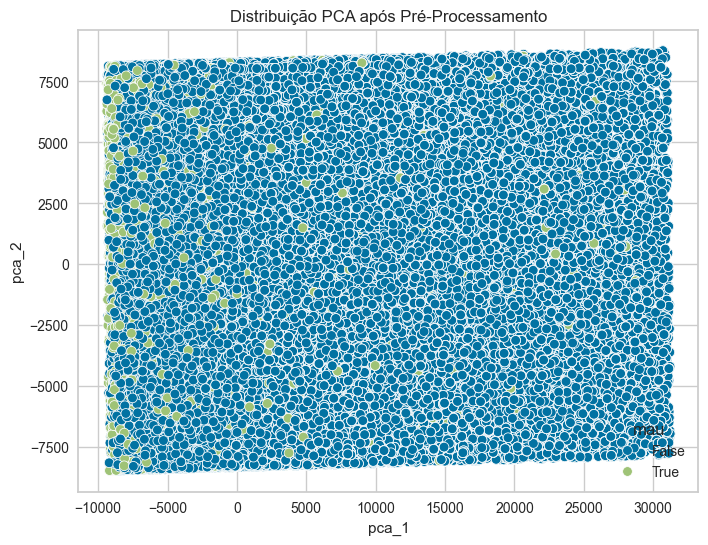

In [6]:
from pycaret.classification import *
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar os dados
df = pd.read_feather('credit_scoring.ftr')

# Função de pré-processamento
def preprocessamento(df):
    df = df.copy()
    
    # Substituição de nulos
    df.fillna(df.median(numeric_only=True), inplace=True)
    
    # Remoção de outliers (usando IQR apenas em colunas numéricas)
    numeric_cols = df.select_dtypes(include=['number']).columns
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    
    # Criando dummies para a variável 'posse_de_veiculo'
    df = pd.get_dummies(df, columns=['posse_de_veiculo'], drop_first=True)
    
    # Aplicando PCA manualmente para reduzir a dimensionalidade
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df[numeric_cols])
    df['pca_1'] = pca_result[:, 0]
    df['pca_2'] = pca_result[:, 1]
    
    return df

# Aplicando o pré-processamento
df = preprocessamento(df)

# Configuração do ambiente PyCaret (otimizado)
setup(
    data=df, 
    target='mau', 
    session_id=123, 
    normalize=True, 
    transformation=True, 
    n_jobs=1,  # Limitar ainda mais o uso de CPU
    fold=3,  # Reduzindo ainda mais os folds da validação cruzada
    remove_multicollinearity=False,  # Desativar remoção de multicolinearidade para economizar memória
    use_gpu=False  
)

# Treinamento do modelo LightGBM (sem validação cruzada para evitar consumo excessivo)
model = create_model('lightgbm', cross_validation=False)

# Avaliação do modelo
plot_model(model, plot='auc')
plot_model(model, plot='confusion_matrix')
plot_model(model, plot='feature')

# Finalizando o pipeline
final_model = finalize_model(model)

# Salvando o pipeline
df_transformed = pull()
save_model(final_model, 'lightgbm_pipeline')

# Exibição dos gráficos finais
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['pca_1'], y=df['pca_2'], hue=df['mau'])
plt.title('Distribuição PCA após Pré-Processamento')
plt.show()